In [29]:
# Install libraries
!pip install -q opencv-python-headless moviepy ultralytics reportlab pillow matplotlib
# ffmpeg
!apt-get -qq install -y ffmpeg


In [30]:
from google.colab import drive
import os, shutil

drive.mount('/content/drive', force_remount=True)

BASE_DIR = "/content/drive/MyDrive/train_project_v2"
RAW_DIR = os.path.join(BASE_DIR, "raw_video")
PROCESSED_DIR = os.path.join(BASE_DIR, "processed")

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)

VIDEO_FILENAME = "train.mp4"
VIDEO_PATH = os.path.join(RAW_DIR, VIDEO_FILENAME)
TRAIN_NUMBER = "12309"
print("Raw video path:", VIDEO_PATH)
print("Processed output path:", PROCESSED_DIR)


Mounted at /content/drive
Raw video path: /content/drive/MyDrive/train_project_v2/raw_video/train.mp4
Processed output path: /content/drive/MyDrive/train_project_v2/processed


In [31]:

import shutil
shutil.rmtree(PROCESSED_DIR, ignore_errors=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)
print("Cleaned processed folder and recreated it.")


Cleaned processed folder and recreated it.


In [32]:
import cv2, numpy as np
from tqdm import tqdm


assert os.path.exists(VIDEO_PATH), f"Video not found at {VIDEO_PATH}. Upload train.mp4 to RAW_DIR."

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count / fps
print(f"Video FPS: {fps:.3f}, frames: {frame_count}, duration: {duration:.2f}s")


SAMPLE_EVERY = 5
roi_means = []
idx = 0
cap_pos = 0

pbar = tqdm(total=frame_count//SAMPLE_EVERY + 1, desc="Sampling ROI brightness")
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    idx += 1
    if idx % SAMPLE_EVERY != 0:
        continue
    h, w = frame.shape[:2]
    roi = frame[int(h*0.8):h, :]
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi_means.append(np.mean(gray))
    pbar.update(1)
pbar.close()
cap.release()

roi_means = np.array(roi_means)
print("Sampled ROI frames:", len(roi_means))
if len(roi_means) == 0:
    raise RuntimeError("No ROI samples collected — check video or SAMPLE_EVERY value.")


Video FPS: 24.186, frames: 2204, duration: 91.13s


Sampling ROI brightness: 100%|█████████▉| 440/441 [00:46<00:00,  9.38it/s]

Sampled ROI frames: 440


ROI mean low/5%=60.1, high/95%=83.4 -> AUTO_THRESHOLD=71.7


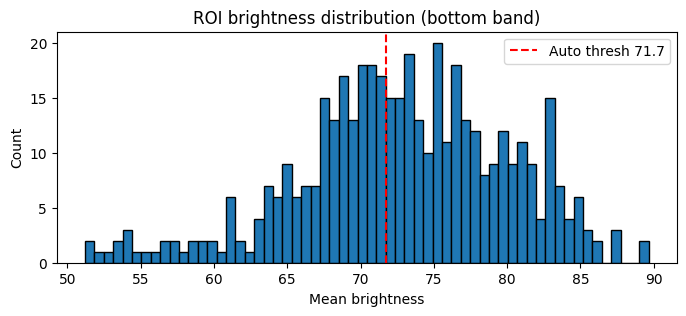

In [33]:
import matplotlib.pyplot as plt
# auto threshold
low, high = np.percentile(roi_means, [5, 95])
AUTO_THRESHOLD = float((low + high) / 2.0)
print(f"ROI mean low/5%={low:.1f}, high/95%={high:.1f} -> AUTO_THRESHOLD={AUTO_THRESHOLD:.1f}")

plt.figure(figsize=(8,3))
plt.hist(roi_means, bins=60, edgecolor='k')
plt.axvline(AUTO_THRESHOLD, color='red', linestyle='--', label=f"Auto thresh {AUTO_THRESHOLD:.1f}")
plt.title("ROI brightness distribution (bottom band)")
plt.xlabel("Mean brightness")
plt.ylabel("Count")
plt.legend()
plt.show()


In [34]:

THRESHOLD = AUTO_THRESHOLD
MIN_GAP_SECONDS = 0.9  # minimum allowed distance between detected boundaries

cap = cv2.VideoCapture(VIDEO_PATH)
boundaries = []
prev_gap = False
frame_idx = 0

pbar = tqdm(total=frame_count, desc="Scanning for boundaries")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1
    h, w = frame.shape[:2]
    roi = frame[int(h*0.8):h, :]
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    mean_val = float(np.mean(gray))
    gap = mean_val < THRESHOLD
    if gap and not prev_gap:
        timestamp = frame_idx / fps
        if len(boundaries) == 0 or (timestamp - boundaries[-1]) > MIN_GAP_SECONDS:
            boundaries.append(timestamp)
            print(f"Detected boundary at {timestamp:.2f}s (roi_mean={mean_val:.1f})")
    prev_gap = gap
    pbar.update(1)
pbar.close()
cap.release()

# append final end timestamp
if len(boundaries) == 0 or boundaries[-1] < duration - 0.01:
    boundaries.append(duration)

# Build segments
segments = []
start = 0.0
for b in boundaries:
    segments.append((start, b))
    start = b

print(f"Detected {len(segments)} segments (boundaries: {len(boundaries)})")



Scanning for boundaries:   3%|▎         | 72/2204 [00:01<00:59, 35.73it/s]

Detected boundary at 2.73s (roi_mean=65.3)


Scanning for boundaries:   5%|▌         | 111/2204 [00:02<00:42, 49.08it/s]

Detected boundary at 4.05s (roi_mean=71.7)


Scanning for boundaries:   6%|▌         | 135/2204 [00:02<00:39, 52.41it/s]

Detected boundary at 5.29s (roi_mean=69.5)


Scanning for boundaries:   8%|▊         | 171/2204 [00:03<00:31, 64.42it/s]

Detected boundary at 6.62s (roi_mean=71.3)


Scanning for boundaries:  10%|█         | 231/2204 [00:04<00:35, 55.51it/s]

Detected boundary at 9.30s (roi_mean=67.5)


Scanning for boundaries:  12%|█▏        | 267/2204 [00:05<00:38, 50.95it/s]

Detected boundary at 10.83s (roi_mean=68.9)


Scanning for boundaries:  13%|█▎        | 296/2204 [00:05<00:36, 51.75it/s]

Detected boundary at 11.83s (roi_mean=70.2)


Scanning for boundaries:  16%|█▌        | 343/2204 [00:06<00:37, 49.72it/s]

Detected boundary at 13.85s (roi_mean=69.7)


Scanning for boundaries:  17%|█▋        | 367/2204 [00:07<00:35, 51.15it/s]

Detected boundary at 14.88s (roi_mean=68.2)


Scanning for boundaries:  19%|█▉        | 416/2204 [00:08<00:34, 52.18it/s]

Detected boundary at 16.91s (roi_mean=70.3)


Scanning for boundaries:  21%|██        | 458/2204 [00:08<00:33, 51.74it/s]

Detected boundary at 18.48s (roi_mean=68.8)


Scanning for boundaries:  22%|██▏       | 476/2204 [00:09<00:31, 55.52it/s]

Detected boundary at 19.43s (roi_mean=70.9)


Scanning for boundaries:  24%|██▍       | 526/2204 [00:10<00:31, 52.77it/s]

Detected boundary at 21.42s (roi_mean=70.4)


Scanning for boundaries:  25%|██▌       | 556/2204 [00:10<00:33, 49.64it/s]

Detected boundary at 22.82s (roi_mean=71.2)


Scanning for boundaries:  27%|██▋       | 603/2204 [00:11<00:31, 50.17it/s]

Detected boundary at 24.60s (roi_mean=66.9)


Scanning for boundaries:  29%|██▉       | 634/2204 [00:12<00:31, 49.83it/s]

Detected boundary at 26.09s (roi_mean=71.5)


Scanning for boundaries:  30%|███       | 670/2204 [00:13<00:46, 33.08it/s]

Detected boundary at 27.58s (roi_mean=66.6)


Scanning for boundaries:  32%|███▏      | 703/2204 [00:14<00:47, 31.44it/s]

Detected boundary at 28.82s (roi_mean=71.5)


Scanning for boundaries:  34%|███▍      | 756/2204 [00:16<00:44, 32.35it/s]

Detected boundary at 30.97s (roi_mean=69.0)


Scanning for boundaries:  35%|███▌      | 776/2204 [00:16<00:43, 33.09it/s]

Detected boundary at 31.92s (roi_mean=70.3)


Scanning for boundaries:  37%|███▋      | 823/2204 [00:17<00:27, 50.27it/s]

Detected boundary at 33.78s (roi_mean=67.1)


Scanning for boundaries:  38%|███▊      | 848/2204 [00:18<00:26, 50.74it/s]

Detected boundary at 34.81s (roi_mean=70.4)


Scanning for boundaries:  41%|████      | 896/2204 [00:19<00:25, 51.54it/s]

Detected boundary at 36.80s (roi_mean=71.3)


Scanning for boundaries:  43%|████▎     | 945/2204 [00:20<00:23, 53.70it/s]

Detected boundary at 38.78s (roi_mean=70.4)


Scanning for boundaries:  44%|████▍     | 974/2204 [00:20<00:24, 50.51it/s]

Detected boundary at 39.90s (roi_mean=70.9)


Scanning for boundaries:  46%|████▌     | 1005/2204 [00:21<00:24, 48.94it/s]

Detected boundary at 41.39s (roi_mean=68.8)


Scanning for boundaries:  47%|████▋     | 1043/2204 [00:22<00:23, 48.40it/s]

Detected boundary at 42.92s (roi_mean=69.6)


Scanning for boundaries:  49%|████▉     | 1083/2204 [00:23<00:21, 51.98it/s]

Detected boundary at 44.41s (roi_mean=69.6)


Scanning for boundaries:  51%|█████     | 1119/2204 [00:23<00:21, 50.67it/s]

Detected boundary at 45.98s (roi_mean=65.2)


Scanning for boundaries:  52%|█████▏    | 1156/2204 [00:24<00:19, 53.70it/s]

Detected boundary at 47.42s (roi_mean=69.5)


Scanning for boundaries:  54%|█████▍    | 1192/2204 [00:25<00:19, 52.25it/s]

Detected boundary at 48.87s (roi_mean=69.0)


Scanning for boundaries:  56%|█████▌    | 1228/2204 [00:25<00:18, 51.62it/s]

Detected boundary at 50.40s (roi_mean=64.7)


Scanning for boundaries:  57%|█████▋    | 1252/2204 [00:26<00:18, 52.71it/s]

Detected boundary at 51.44s (roi_mean=71.5)


Scanning for boundaries:  58%|█████▊    | 1277/2204 [00:26<00:17, 53.97it/s]

Detected boundary at 52.47s (roi_mean=71.7)


Scanning for boundaries:  60%|██████    | 1329/2204 [00:27<00:24, 36.37it/s]

Detected boundary at 54.83s (roi_mean=70.1)


Scanning for boundaries:  62%|██████▏   | 1369/2204 [00:29<00:25, 33.03it/s]

Detected boundary at 56.36s (roi_mean=70.1)


Scanning for boundaries:  64%|██████▎   | 1405/2204 [00:30<00:25, 31.28it/s]

Detected boundary at 57.89s (roi_mean=69.8)


Scanning for boundaries:  65%|██████▍   | 1426/2204 [00:31<00:27, 27.94it/s]

Detected boundary at 58.79s (roi_mean=70.9)


Scanning for boundaries:  67%|██████▋   | 1484/2204 [00:32<00:15, 45.05it/s]

Detected boundary at 61.07s (roi_mean=70.7)


Scanning for boundaries:  69%|██████▊   | 1511/2204 [00:33<00:14, 48.03it/s]

Detected boundary at 62.23s (roi_mean=71.6)


Scanning for boundaries:  72%|███████▏  | 1589/2204 [00:34<00:12, 48.40it/s]

Detected boundary at 65.45s (roi_mean=68.5)


Scanning for boundaries:  73%|███████▎  | 1619/2204 [00:35<00:11, 51.74it/s]

Detected boundary at 66.49s (roi_mean=71.1)


Scanning for boundaries:  75%|███████▌  | 1661/2204 [00:36<00:10, 51.86it/s]

Detected boundary at 68.30s (roi_mean=71.6)


Scanning for boundaries:  77%|███████▋  | 1699/2204 [00:36<00:10, 49.01it/s]

Detected boundary at 69.92s (roi_mean=71.4)


Scanning for boundaries:  79%|███████▉  | 1738/2204 [00:37<00:09, 50.71it/s]

Detected boundary at 71.53s (roi_mean=70.5)


Scanning for boundaries:  82%|████████▏ | 1813/2204 [00:39<00:07, 51.69it/s]

Detected boundary at 74.59s (roi_mean=69.8)


Scanning for boundaries:  84%|████████▍ | 1851/2204 [00:39<00:06, 51.93it/s]

Detected boundary at 76.12s (roi_mean=69.2)


Scanning for boundaries:  86%|████████▌ | 1899/2204 [00:40<00:05, 51.38it/s]

Detected boundary at 78.10s (roi_mean=70.0)


Scanning for boundaries:  87%|████████▋ | 1923/2204 [00:41<00:05, 52.77it/s]

Detected boundary at 79.14s (roi_mean=66.5)


Scanning for boundaries:  88%|████████▊ | 1947/2204 [00:41<00:05, 50.80it/s]

Detected boundary at 80.17s (roi_mean=69.9)


Scanning for boundaries:  89%|████████▉ | 1963/2204 [00:42<00:06, 39.81it/s]

Detected boundary at 81.08s (roi_mean=68.5)


Scanning for boundaries:  90%|█████████ | 1986/2204 [00:43<00:12, 17.72it/s]

Detected boundary at 82.07s (roi_mean=69.5)


Scanning for boundaries:  93%|█████████▎| 2040/2204 [00:47<00:06, 24.15it/s]

Detected boundary at 84.22s (roi_mean=68.9)


Scanning for boundaries:  94%|█████████▍| 2078/2204 [00:48<00:02, 47.43it/s]

Detected boundary at 85.71s (roi_mean=71.5)


Scanning for boundaries:  96%|█████████▌| 2106/2204 [00:48<00:01, 52.94it/s]

Detected boundary at 86.83s (roi_mean=65.3)


Scanning for boundaries: 100%|██████████| 2204/2204 [00:50<00:00, 43.60it/s]

Detected 56 segments (boundaries: 56)


In [35]:
labels = []
for i in range(1, len(segments)+1):
    if i <= 2:
        lbl = f"{TRAIN_NUMBER}_engine_{i}"
    elif i == len(segments):
        lbl = f"{TRAIN_NUMBER}_brakevan_1"
    else:
        lbl = f"{TRAIN_NUMBER}_coach_{i-2}"
    labels.append(lbl)

print("Labels count:", len(labels))
print("Sample start labels:", labels[:6])
print("Sample end labels:", labels[-4:])


Labels count: 56
Sample start labels: ['12309_engine_1', '12309_engine_2', '12309_coach_1', '12309_coach_2', '12309_coach_3', '12309_coach_4']
Sample end labels: ['12309_coach_51', '12309_coach_52', '12309_coach_53', '12309_brakevan_1']


In [36]:
import subprocess, os

def fast_cut(video_path, start, end, out_file):
    # -ss and -to after -i for accuracy; -c copy to avoid re-encoding.
    cmd = [
        "ffmpeg", "-y", "-i", video_path,
        "-ss", f"{start:.3f}", "-to", f"{end:.3f}",
        "-c", "copy", out_file
    ]
    try:
        subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
        return os.path.exists(out_file)
    except Exception as e:
        print("ffmpeg cut failed:", e)
        return False


SAVE_SEGMENTS = True

if SAVE_SEGMENTS:
    print("Saving segments to processed folders (fast copy mode)...")
    for idx, (s,e) in enumerate(segments, 1):
        folder = os.path.join(PROCESSED_DIR, f"{TRAIN_NUMBER}_{idx}")
        os.makedirs(folder, exist_ok=True)
        out_file = os.path.join(folder, f"{TRAIN_NUMBER}_{idx}.mp4")
        if os.path.exists(out_file):
            print(f"Segment {idx} already exists, skipping.")
            continue
        ok = fast_cut(VIDEO_PATH, s, e, out_file)
        print(f"Saved {idx}: {ok}  ({s:.2f} - {e:.2f}s)")
else:
    print("Skipping saving segment mp4 files (set SAVE_SEGMENTS = True to enable).")


Saving segments to processed folders (fast copy mode)...
Saved 1: True  (0.00 - 2.73s)
Saved 2: True  (2.73 - 4.05s)
Saved 3: True  (4.05 - 5.29s)
Saved 4: True  (5.29 - 6.62s)
Saved 5: True  (6.62 - 9.30s)
Saved 6: True  (9.30 - 10.83s)
Saved 7: True  (10.83 - 11.83s)
Saved 8: True  (11.83 - 13.85s)
Saved 9: True  (13.85 - 14.88s)
Saved 10: True  (14.88 - 16.91s)
Saved 11: True  (16.91 - 18.48s)
Saved 12: True  (18.48 - 19.43s)
Saved 13: True  (19.43 - 21.42s)
Saved 14: True  (21.42 - 22.82s)
Saved 15: True  (22.82 - 24.60s)
Saved 16: True  (24.60 - 26.09s)
Saved 17: True  (26.09 - 27.58s)
Saved 18: True  (27.58 - 28.82s)
Saved 19: True  (28.82 - 30.97s)
Saved 20: True  (30.97 - 31.92s)
Saved 21: True  (31.92 - 33.78s)
Saved 22: True  (33.78 - 34.81s)
Saved 23: True  (34.81 - 36.80s)
Saved 24: True  (36.80 - 38.78s)
Saved 25: True  (38.78 - 39.90s)
Saved 26: True  (39.90 - 41.39s)
Saved 27: True  (41.39 - 42.92s)
Saved 28: True  (42.92 - 44.41s)
Saved 29: True  (44.41 - 45.98s)
Saved 

In [37]:
import cv2, math

def extract_frames_from_segment(video_path, start, end, label, out_folder, num_images=3):
    os.makedirs(out_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    start_f = int(start * fps)
    end_f = int(end * fps)
    total = max(1, end_f - start_f)
    step = max(1, total // num_images)
    saved = []
    for i in range(start_f, end_f, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue
        fname = os.path.join(out_folder, f"{label}_{i}.jpg")
        cv2.imwrite(fname, frame)
        saved.append(fname)
        if len(saved) >= num_images:
            break
    cap.release()
    return saved

coverage_images = []
for idx, ((s,e), lbl) in enumerate(zip(segments, labels), 1):

    seg_folder = os.path.join(PROCESSED_DIR, f"{TRAIN_NUMBER}_{idx}")
    frames_folder = os.path.join(seg_folder, "frames")
    imgs = extract_frames_from_segment(VIDEO_PATH, s, e, lbl, frames_folder, num_images=3)
    coverage_images.append((lbl, imgs))
    print(f"{lbl}: extracted {len(imgs)} frames -> {frames_folder}")


12309_engine_1: extracted 3 frames -> /content/drive/MyDrive/train_project_v2/processed/12309_1/frames
12309_engine_2: extracted 3 frames -> /content/drive/MyDrive/train_project_v2/processed/12309_2/frames
12309_coach_1: extracted 3 frames -> /content/drive/MyDrive/train_project_v2/processed/12309_3/frames
12309_coach_2: extracted 3 frames -> /content/drive/MyDrive/train_project_v2/processed/12309_4/frames
12309_coach_3: extracted 3 frames -> /content/drive/MyDrive/train_project_v2/processed/12309_5/frames
12309_coach_4: extracted 3 frames -> /content/drive/MyDrive/train_project_v2/processed/12309_6/frames
12309_coach_5: extracted 3 frames -> /content/drive/MyDrive/train_project_v2/processed/12309_7/frames
12309_coach_6: extracted 3 frames -> /content/drive/MyDrive/train_project_v2/processed/12309_8/frames
12309_coach_7: extracted 3 frames -> /content/drive/MyDrive/train_project_v2/processed/12309_9/frames
12309_coach_8: extracted 3 frames -> /content/drive/MyDrive/train_project_v2/pro

In [42]:
annotated_summary = {}
for i, (lbl, imgs) in enumerate(coverage_images, 1):
    seg_folder = os.path.join(PROCESSED_DIR, f"{TRAIN_NUMBER}_{i}")
    ann_folder = os.path.join(seg_folder, "annotated_final")
    os.makedirs(ann_folder, exist_ok=True)

    total_doors = 0
    open_doors = 0
    ann_files = []

    for img_path in imgs:
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Detect doors only for engines
        dets = []
        if "engine" in lbl.lower():
            dets = detect_doors_in_image(img)

        for d in dets:
            x1,y1,x2,y2 = d['bbox']
            lab = d['label']
            color = (0,255,0) if lab=="door_closed" else (0,0,255)
            cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
            cv2.putText(img, lab, (x1, max(15,y1-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
            total_doors += 1
            if lab == "door_open":
                open_doors += 1

        ann_name = os.path.join(ann_folder, "annot_" + os.path.basename(img_path))
        cv2.imwrite(ann_name, img)
        ann_files.append(ann_name)

    annotated_summary[lbl] = {
        "annotated_images": ann_files,
        "door_count": total_doors,
        "door_open_count": open_doors,
        "original_images": imgs
    }

    print(f"{lbl}: doors={total_doors}, open={open_doors}, imgs={len(imgs)}")


12309_engine_1: doors=8, open=8, imgs=3
12309_engine_2: doors=4, open=2, imgs=3
12309_coach_1: doors=0, open=0, imgs=3
12309_coach_2: doors=0, open=0, imgs=3
12309_coach_3: doors=0, open=0, imgs=3
12309_coach_4: doors=0, open=0, imgs=3
12309_coach_5: doors=0, open=0, imgs=3
12309_coach_6: doors=0, open=0, imgs=3
12309_coach_7: doors=0, open=0, imgs=3
12309_coach_8: doors=0, open=0, imgs=3
12309_coach_9: doors=0, open=0, imgs=3
12309_coach_10: doors=0, open=0, imgs=3
12309_coach_11: doors=0, open=0, imgs=3
12309_coach_12: doors=0, open=0, imgs=3
12309_coach_13: doors=0, open=0, imgs=3
12309_coach_14: doors=0, open=0, imgs=3
12309_coach_15: doors=0, open=0, imgs=3
12309_coach_16: doors=0, open=0, imgs=3
12309_coach_17: doors=0, open=0, imgs=3
12309_coach_18: doors=0, open=0, imgs=3
12309_coach_19: doors=0, open=0, imgs=3
12309_coach_20: doors=0, open=0, imgs=3
12309_coach_21: doors=0, open=0, imgs=3
12309_coach_22: doors=0, open=0, imgs=3
12309_coach_23: doors=0, open=0, imgs=3
12309_coa

In [43]:
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle, PageBreak
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

report_path = os.path.join(PROCESSED_DIR, f"{TRAIN_NUMBER}_final_report.pdf")
doc = SimpleDocTemplate(report_path)
styles = getSampleStyleSheet()
story = []

story.append(Paragraph("Train Coverage Report", styles["Title"]))
story.append(Spacer(1, 20))
story.append(Paragraph(f"Train Number: {TRAIN_NUMBER}", styles["Heading2"]))
story.append(Spacer(1, 20))

num_engines = sum(1 for l in labels if "engine" in l)
num_brakevans = sum(1 for l in labels if "brakevan" in l)
num_coaches = sum(1 for l in labels if "coach" in l)
total_segments = len(labels)

summary_data = [
    ["Category", "Count", "Details"],
    ["Engines", num_engines, "Front locomotives (with door analysis)"],
    ["Coaches", num_coaches, "Transfer wagons (no doors)"],
    ["Brakevans", num_brakevans, "End of train (no doors)"],
    ["Total Segments", total_segments, f"{total_segments} units detected"]
]

table = Table(summary_data, colWidths=[120,80,250])
table.setStyle(TableStyle([
    ("BACKGROUND",(0,0),(-1,0), colors.lightgrey),
    ("ALIGN",(0,0),(-1,-1),"CENTER"),
    ("GRID",(0,0),(-1,-1),0.5,colors.grey),
    ("FONTNAME",(0,0),(-1,0),"Helvetica-Bold")
]))
story.append(table)
story.append(Spacer(1, 30))
story.append(PageBreak())


for lbl in labels:
    info = annotated_summary.get(lbl, None)
    if info is None:
        continue

    doors = info.get("door_count", 0)
    open_doors = info.get("door_open_count", 0)

    story.append(Paragraph(lbl, styles["Heading2"]))
    if "engine" in lbl.lower():
        story.append(Paragraph(f"Detected doors: {doors}, Doors open: {open_doors}", styles["Normal"]))
    else:
        story.append(Paragraph("No doors detected for this coach/wagon.", styles["Normal"]))
    story.append(Spacer(1, 10))

    # add annotated images
    for ann in info['annotated_images']:
        try:
            story.append(Image(ann, width=400, height=200))
            story.append(Spacer(1, 8))
        except Exception as e:
            print("Skipping image:", ann, e)

    story.append(PageBreak())

doc.build(story)
print("✅ Final report generated at:", report_path)


✅ Final report generated at: /content/drive/MyDrive/train_project_v2/processed/12309_final_report.pdf
